In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid

from google.colab import files, drive
from IPython import display
from PIL import Image
from tqdm import tqdm

import cv2
import imagesize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import time

import xml.etree.ElementTree as ET

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Constant Variable

In [3]:
DATASET = 'ZOOANIMALS'
DIR_RESIZED = 'RESIZED_DATASET' # where to store resized image
OUTPUT_DIR = 'GENERATED_IMAGE' # generated images location
GDRIVE_PARENT_PATH = '/content/drive/MyDrive/IF5281'
USED_CATEGORY = ['cat', 'dog', 'penguin', 'zebra', 'giraffe', 'elephant', 'sheep', 'turtle']
CLASS_NUM = len(USED_CATEGORY)

NC = 3 # image channel
IMG_SIZE = 64 # image size for training
BATCH_SIZE = 32 # training batch size
NZ = 100 # num of latent space
NGF = 128 # num generator filters
NDF = 128 # num discriminator filters
LR = 2e-4 # learning rate
BETA1 = 0.5 # beta1 for Adam optimizer
EPOCHS = 100 # num of epochs
NGPU = 1 # num GPUs
DOWN_SAMPLING_SIZE = 1500 # number of image each category

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = f'{DATASET}-{NC}-{IMG_SIZE}-{BATCH_SIZE}-{NZ}-{NGF}-{NDF}-{LR}-{BETA1}-{EPOCHS}-{DOWN_SAMPLING_SIZE}-{DEVICE}'.upper()
MODEL_OUTPUT_DIR = os.path.join(GDRIVE_PARENT_PATH, MODEL_NAME)
DIR_RESIZED = f'DIR_RESIZED_{IMG_SIZE}'
MODEL_NAME

'ZOOANIMALS-3-64-32-100-128-128-0.0002-0.5-100-1500-CUDA'

In [4]:
# Create directories

if not os.path.isdir(DIR_RESIZED):
    print(f'Creating DIR_RESIZED: {DIR_RESIZED}')
    os.makedirs(DIR_RESIZED)

if not os.path.isdir(OUTPUT_DIR):
    print(f'Creating OUTPUT_DIR: {OUTPUT_DIR}')
    os.makedirs(OUTPUT_DIR)

if not os.path.isdir(GDRIVE_PARENT_PATH):
    print(f'Creating GDRIVE_PARENT_PATH: {GDRIVE_PARENT_PATH}')
    os.makedirs(GDRIVE_PARENT_PATH)

if not os.path.isdir(MODEL_OUTPUT_DIR):
    print(f'Creating MODEL_OUTPUT_DIR: {MODEL_OUTPUT_DIR}')
    os.makedirs(MODEL_OUTPUT_DIR)

Creating DIR_RESIZED: DIR_RESIZED_64
Creating OUTPUT_DIR: GENERATED_IMAGE
Creating GDRIVE_PARENT_PATH: /content/drive/MyDrive/IF5281
Creating MODEL_OUTPUT_DIR: /content/drive/MyDrive/IF5281/ZOOANIMALS-3-64-32-100-128-128-0.0002-0.5-100-1500-CUDA


In [5]:
!nvidia-smi

Thu May 25 16:17:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data from Kaggle

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"linkgish","key":"e95b128abf7dfeb6e922840162ad9f81"}'}

In [7]:
# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d jirkadaberger/zoo-animals --force

100% 6.05G/6.05G [05:28<00:00, 19.0MB/s]
100% 6.05G/6.05G [05:28<00:00, 19.8MB/s]


In [9]:
!unzip -q /content/zoo-animals.zip -d /content/dataset

# Exploratory Data Analysis

## Load Data into Pandas DataFrame

In [10]:
DATASET_PATH = '/content/dataset'
category_paths = os.listdir(DATASET_PATH)
category_paths

['cow',
 'rhino',
 'flamingo',
 'parrot',
 'elephant',
 'lion',
 'penguin',
 'capybara',
 'tiger',
 'dog',
 'buffalo',
 'turtle',
 'giraffe',
 'zebra',
 'kangaroo',
 'cat',
 'sheep',
 'deer',
 'jaguar']

In [11]:
img_files_dict = {}

for category in category_paths:
    all_files = []

    category_path = os.path.join(DATASET_PATH, category)
    train_path = os.path.join(category_path, 'train')
    test_path = os.path.join(category_path, 'train')

    if os.path.isdir(category_path):
        category_files = [os.path.join(category_path, f) for f in os.listdir(category_path)]
        all_files += category_files

    if os.path.isdir(train_path):
        train_files = [os.path.join(train_path, f) for f in os.listdir(train_path)]
        all_files += train_files

    if os.path.isdir(test_path):
        test_files = [os.path.join(test_path, f) for f in os.listdir(test_path)]
        all_files += test_files
    
    img_files = [f for f in all_files if 'jpg' in f.lower()]
    img_files_dict[category] = img_files
    print(category, len(img_files), img_files[0])

cow 7068 /content/dataset/cow/train/Cow_Download_train_2587.jpg
rhino 2412 /content/dataset/rhino/train/Rhino_Dow_126.jpg
flamingo 100 /content/dataset/flamingo/Flamingo_438.jpg
parrot 3618 /content/dataset/parrot/train/Parrot_Download_train_197.jpg
elephant 4112 /content/dataset/elephant/train/Elephant_Dow_342.jpg
lion 2492 /content/dataset/lion/train/Lion_Download_train_266.jpg
penguin 5026 /content/dataset/penguin/train/Penguin_Download_3_train_463.jpg
capybara 1344 /content/dataset/capybara/train/Capybara_547.jpg
tiger 3870 /content/dataset/tiger/train/Tiger_1236.jpg
dog 5720 /content/dataset/dog/train/Dog_Download_2_3831.jpg
buffalo 502 /content/dataset/buffalo/train/Buffalo_Download_111.jpg
turtle 1670 /content/dataset/turtle/train/Turtle_1562.jpg
giraffe 1902 /content/dataset/giraffe/train/Giraffe_Download_2_202.jpg
zebra 4068 /content/dataset/zebra/train/Zebra_Download_5_64.jpg
kangaroo 2640 /content/dataset/kangaroo/train/Kangaroo_Download_1_56.jpg
cat 5588 /content/dataset/ca

In [12]:
# take some category that interesting
for c in USED_CATEGORY:
  img_files = img_files_dict[c]
  print(c, len(img_files))

cat 5588
dog 5720
penguin 5026
zebra 4068
giraffe 1902
elephant 4112
sheep 5220
turtle 1670


In [13]:
random.seed(0)

img_data = [['category', 'width', 'height', 'img_path']]
for category in img_files_dict:
    if category in USED_CATEGORY:
        img_files = img_files_dict[category]
        img_selected = random.sample(img_files, DOWN_SAMPLING_SIZE)
        for img_path in img_selected:
            width, height = imagesize.get(img_path)
            img_data.append([category, width, height, img_path])


df_original = pd.DataFrame(img_data[1:], columns=img_data[0])
df_original

,category,width,height,img_path
0,elephant,416,416,/content/dataset/elephant/train/Elephant_Downl...
1,elephant,640,335,/content/dataset/elephant/train/Elephant_Dow_4...
2,elephant,416,416,/content/dataset/elephant/train/Elephant_Downl...
3,elephant,416,416,/content/dataset/elephant/train/Elephant_Downl...
4,elephant,416,416,/content/dataset/elephant/train/Elephant_Downl...
...,...,...,...,...
11995,sheep,1000,699,/content/dataset/sheep/train/Sheep_Download_tr...
11996,sheep,416,416,/content/dataset/sheep/train/Sheep_Download_tr...
11997,sheep,500,332,/content/dataset/sheep/train/Sheep_Download_tr...
11998,sheep,416,416,/content/dataset/sheep/train/Sheep_Download_tr...


## Check Data Values

In [14]:
df_original['category'].unique()

array(['elephant', 'penguin', 'dog', 'turtle', 'giraffe', 'zebra', 'cat',
       'sheep'], dtype=object)

In [15]:
print(f"There are {len(df_original['category'].unique())} categories of animal")

There are 8 categories of animal


In [16]:
df_original['category'].value_counts().reset_index()

,index,category
0,elephant,1500
1,penguin,1500
2,dog,1500
3,turtle,1500
4,giraffe,1500
5,zebra,1500
6,cat,1500
7,sheep,1500


In [17]:
print(f"Minimum width is {df_original['width'].min()} and maximum width is {df_original['width'].max()}")
print(f"Minimum height is {df_original['height'].min()} and maximum height is {df_original['height'].max()}")

Minimum width is 333 and maximum width is 6033
Minimum height is 331 and maximum height is 4826


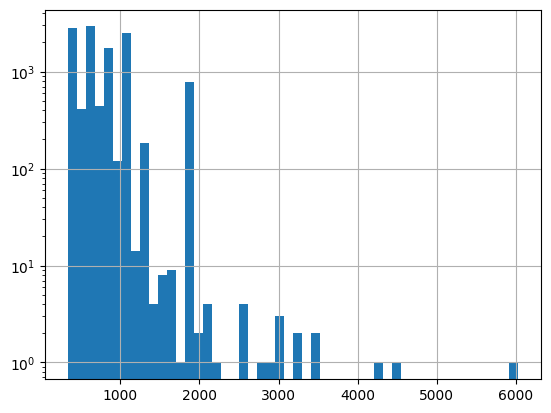

In [18]:
df_original['width'].hist(log=True, bins=50);

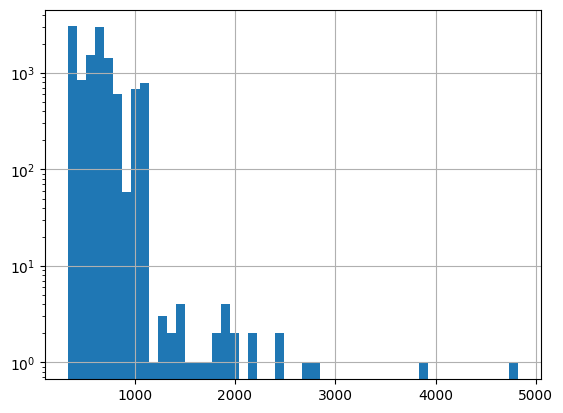

In [19]:
df_original['height'].hist(log=True, bins=50);

## Explore Images

In [20]:
df_original.head(3)

,category,width,height,img_path
0,elephant,416,416,/content/dataset/elephant/train/Elephant_Downl...
1,elephant,640,335,/content/dataset/elephant/train/Elephant_Dow_4...
2,elephant,416,416,/content/dataset/elephant/train/Elephant_Downl...


In [21]:
np.random.seed(0)
df_sample = df_original.groupby('category').apply(lambda s: s.sample(2))
df_sample

category  width  height  \
category                                  
cat      9471        cat    811    1024   
         9009        cat    977    1024   
dog      4068        dog   1024     732   
         4106        dog   1024     683   
elephant 1212   elephant    416     416   
         1340   elephant    416     416   
giraffe  6273    giraffe    800     571   
         6675    giraffe    531     800   
penguin  2305    penguin    416     416   
         1840    penguin    640     640   
sheep    11691     sheep    416     416   
         11970     sheep    416     416   
turtle   4897     turtle    640     640   
         5189     turtle    800     598   
zebra    7637      zebra    800     640   
         8606      zebra    640     427   

                                                         img_path  
category                                                           
cat      9471   /content/dataset/cat/train/Cat_Download_2_1418...  
         9009   /content/dataset/cat/train/Cat_Download_2_2451...  
dog      4068   /content/dataset/dog/train/Dog_Download_2_2055...  
         4106   /content/dataset/dog/train/Dog_Download_2_2323...  
elephant 1212   /content/dataset/elephant/train/Elephant_Downl...  
         1340   /content/dataset/elephant/train/Elephant_Downl...  
giraffe  6273      /content/dataset/giraffe/train/Giraffe_440.jpg  
         6675     /content/dataset/giraffe/train/Giraffe_1235.jpg  
penguin  2305   /content/dataset/penguin/train/Penguin_Downloa...  
         1840   /content/dataset/penguin/train/Penguin_Downloa...  
sheep    11691  /content/dataset/sheep/train/Sheep_Download_tr...  
         11970  /content/dataset/sheep/train/Sheep_Download_tr...  
turtle   4897   /content/dataset/turtle/train/Turtle_Download_...  
         5189       /content/dataset/turtle/train/Turtle_1308.jpg  
zebra    7637          /content/dataset/zebra/train/Zebra_200.jpg  
         8606       /content/dataset/zebra/train/Zebra_Dow_64.jpg

100%|██████████| 16/16 [00:00<00:00, 34.28it/s]


Showing pictures


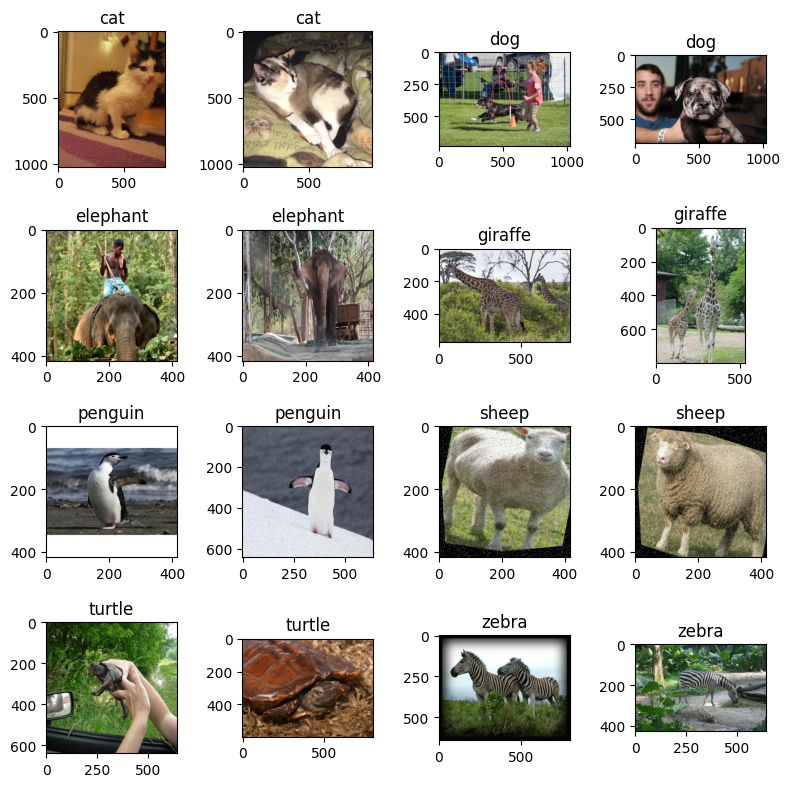

In [22]:
def plot_sample_img(arr):
    n_col = 4
    n_row = 4
    assert n_col * n_row >= len(arr) # dimesion should match

    f, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

    cnt = 0
    with tqdm(total=n_col*n_row) as pbar:
        for r in range(n_row):
            for c in range(n_col):
                if cnt < len(arr):
                    category, width, height, img_path = arr[cnt]
                    im = cv2.imread(img_path)
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                    axes[r][c].imshow(im)
                    axes[r][c].set_title(category)
                    cnt+=1
                pbar.update(1)
    f.tight_layout()
    f.show()
    print('Showing pictures')

plot_sample_img(df_sample.values)

# Data Preprocessing

In [23]:
# create resized dataset directory
if not os.path.isdir(DIR_RESIZED):
    print(f'Create new directory {DIR_RESIZED}')
    os.makedirs(DIR_RESIZED)

In [24]:
for category in USED_CATEGORY:
    dir_cat = os.path.join(DIR_RESIZED, category)
    if not os.path.isdir(dir_cat):
        print(f'Create new directory {category}')
        os.makedirs(dir_cat)

Create new directory cat
Create new directory dog
Create new directory penguin
Create new directory zebra
Create new directory giraffe
Create new directory elephant
Create new directory sheep
Create new directory turtle


In [25]:
arr_img = df_original[['category', 'img_path']].values
arr_resized_img = []
for idx, (category, img_original_path) in enumerate(tqdm(arr_img)):
    img_resized_path = os.path.join(DIR_RESIZED, category, f'{idx}.jpg')
    if os.path.isfile(img_resized_path):
        pass
    else:
        img = Image.open(img_original_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        img.save(img_resized_path)

    arr_resized_img.append([category, img_resized_path])

df_img = pd.DataFrame(arr_resized_img, columns=['category', 'img_path'])
df_img

100%|██████████| 12000/12000 [03:49<00:00, 52.22it/s] 


,category,img_path
0,elephant,DIR_RESIZED_64/elephant/0.jpg
1,elephant,DIR_RESIZED_64/elephant/1.jpg
2,elephant,DIR_RESIZED_64/elephant/2.jpg
3,elephant,DIR_RESIZED_64/elephant/3.jpg
4,elephant,DIR_RESIZED_64/elephant/4.jpg
...,...,...
11995,sheep,DIR_RESIZED_64/sheep/11995.jpg
11996,sheep,DIR_RESIZED_64/sheep/11996.jpg
11997,sheep,DIR_RESIZED_64/sheep/11997.jpg
11998,sheep,DIR_RESIZED_64/sheep/11998.jpg


100%|██████████| 16/16 [00:00<00:00, 704.55it/s]


Showing pictures


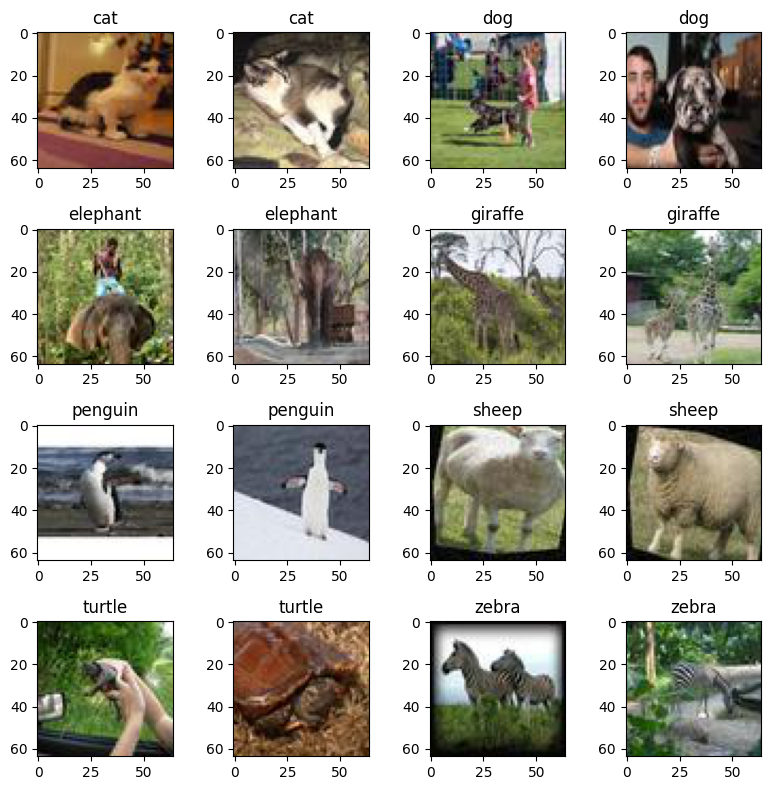

In [26]:
def plot_sample_from_df_img(df_img_source):
    arr = df_img_source[['category', 'img_path']].values
    n_col = 4
    n_row = 4
    assert n_col * n_row >= len(arr) # dimesion should match

    f, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

    cnt = 0
    with tqdm(total=n_col*n_row) as pbar:
        for r in range(n_row):
            for c in range(n_col):
                if cnt < len(arr):
                    category, img_path = arr[cnt]
                    img = Image.open(img_path)
                    axes[r][c].imshow(np.asarray(img))
                    axes[r][c].set_title(category)
                    cnt+=1
                    pbar.update(1)
    f.tight_layout()
    f.show()
    print('Showing pictures')

np.random.seed(0)
df_img_sample = df_img.groupby('category').apply(lambda s: s.sample(2))
plot_sample_from_df_img(df_img_sample)

# Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)

## Dataset loader

In [27]:
# df_img['category_id'] = df_img['category'].apply(lambda x: x.cat.codes)

df_img['category_id'] = df_img['category'].astype('category')
df_img['category_id'] = df_img['category_id'].cat.codes
df_cat_id_map = df_img[['category_id', 'category']].drop_duplicates()
cat_id_map = df_cat_id_map.set_index('category_id').to_dict()["category"]
cat_id_map

{2: 'elephant',
 4: 'penguin',
 1: 'dog',
 6: 'turtle',
 3: 'giraffe',
 7: 'zebra',
 0: 'cat',
 5: 'sheep'}

In [28]:
df_img.head(5)

,category,img_path,category_id
0,elephant,DIR_RESIZED_64/elephant/0.jpg,2
1,elephant,DIR_RESIZED_64/elephant/1.jpg,2
2,elephant,DIR_RESIZED_64/elephant/2.jpg,2
3,elephant,DIR_RESIZED_64/elephant/3.jpg,2
4,elephant,DIR_RESIZED_64/elephant/4.jpg,2


In [29]:
class MainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.labels = df['category_id'].values.tolist()
        self.images = df['img_path'].values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.open(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [30]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = MainDataset(df_img, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Define the models

In [31]:
# Define custom weights initialization
def weights_init(model) :
  classname = model.__class__.__name__
  if classname.find("Conv") != -1 :
    torch.nn.init.normal_(model.weight, .0, .02)
  elif classname.find("BatchNorm") != -1 :
    torch.nn.init.normal_(model.weight, 1., .02)
    torch.nn.init.zeros_(model.bias)

### Generator

In [32]:
# Define model architecture and loss function
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, ngpu=0):
        super().__init__()

        self.ngpu = ngpu

        self.latent_embedding = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(.2, inplace=True)
        )

        self.label_embedding = nn.Sequential(
            nn.ConvTranspose2d(CLASS_NUM, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(.2, inplace=True)
        )

        self.network = nn.Sequential(
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(inplace=True),

            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(inplace=True),

            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(inplace=True),

            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 64 x 64
        )
    
    def forward(self, input):
        noise_vector, label = input
        x = self.latent_embedding(noise_vector)
        y = self.label_embedding(label)
        
        concat = torch.cat([x, y], dim=1)
        
        if noise_vector.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.network, concat, range(self.ngpu))
        else:
            output = self.network(concat)
        # print('G OUTPUT SHAPE', output.shape)
        return output

In [33]:
generator = Generator(NZ, NGF, NC, ngpu=NGPU).to(DEVICE)
generator.apply(weights_init)
print(generator)

Generator(
  (latent_embedding): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label_embedding): Sequential(
    (0): ConvTranspose2d(8, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (network): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): L

### Discriminator

In [34]:
class Discriminator(nn.Module):
    def __init__(self, nz, ndf, nc, ngpu=0):
        super().__init__()
        self.ngpu = ngpu

        self.image_embedding = nn.Sequential(
            nn.Conv2d(nc, ndf//2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.label_embedding = nn.Sequential(
            nn.Conv2d(CLASS_NUM, ndf//2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.network = nn.Sequential(
            # state size: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf * 8) x 4 x 4
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 0, bias=False),
            nn.BatchNorm2d(num_features=ndf * 16),
            nn.LeakyReLU(.2, inplace=True),

            nn.Flatten(),
            nn.Dropout(.4),
            nn.Linear(in_features=ndf * 16, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        image, label = input
        x = self.image_embedding(image)
        y = self.label_embedding(label)

        concat = torch.cat([x, y], dim=1)

        if image.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.network, concat, range(self.ngpu))
        else:
            output = self.network(concat)
        # print('D OUTPUT SHAPE', output.shape)
        return output

In [35]:
discriminator = Discriminator(NZ, NDF, NC, ngpu=NGPU).to(DEVICE)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (image_embedding): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label_embedding): Sequential(
    (0): Conv2d(8, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (network): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, af

## Define optimizer and loss function

In [36]:
# Define optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, .999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, .999))

# Loss function
criterion = nn.BCELoss()

## Onehot encoder layer

In [37]:
# label preprocess using onehot encoder
onehot = torch.zeros(CLASS_NUM, CLASS_NUM)
onehot = onehot.scatter_(1, torch.LongTensor(list(range(CLASS_NUM))).view(CLASS_NUM,1), 1).view(CLASS_NUM, CLASS_NUM, 1, 1)
fill = torch.zeros([CLASS_NUM, CLASS_NUM, IMG_SIZE, IMG_SIZE])
for i in range(CLASS_NUM):
    fill[i, i, :, :] = 1

onehot, fill = onehot.to(DEVICE), fill.to(DEVICE)
onehot.shape, fill.shape

(torch.Size([8, 8, 1, 1]), torch.Size([8, 8, 64, 64]))

## Define training step script for each generator and discriminator

### Generator

In [38]:
def generator_train_step(batch_size, generator_model, discriminator_model, g_optimizer, criterion, real_labels=None) :
  # Initialize gradients
  g_optimizer.zero_grad()
  # Building latent space (z)
  z = Variable(torch.randn(batch_size, NZ)).to(DEVICE)
  # Building fake labels
  fake_labels = Variable(torch.LongTensor(np.random.randint(0, CLASS_NUM, batch_size))).to(DEVICE)
  # Generating fake images
  fake_images = generator_model((z.view(-1, NZ, 1, 1), onehot[fake_labels]))
  # Discriminating fake images using discriminator model
  validity = discriminator_model((fake_images, fill[fake_labels.squeeze()])).squeeze()
  # Calculating discrimination loss (from fake images)
  g_loss = criterion(validity, Variable(torch.ones(validity.size(0))).to(DEVICE))
  # Backward propagation (computing gradient descent)
  g_loss.backward()
  # Update generator model parameters
  g_optimizer.step()
  return g_loss.data

### Discriminator

In [39]:
def discriminator_train_step(batch_size, generator_model, discriminator_model, d_optimizer, criterion, real_images, real_labels) :
  # Initizalize gradients
  d_optimizer.zero_grad()

  # Loss from real images
  ## Discriminating real images
  real_validity = discriminator_model((real_images, fill[real_labels])).squeeze()
  ## Calculating discrimination loss (from real images)
  real_loss = criterion(real_validity, Variable(torch.ones(real_validity.size(0))).to(DEVICE))
  # Loss from fake generated images
  ## Building latent space (z)
  z = Variable(torch.randn(batch_size, NZ)).to(DEVICE)
  ## Building fake labels
  fake_labels = Variable(torch.LongTensor(np.random.randint(0, CLASS_NUM, batch_size))).to(DEVICE)
  ## Generating fake images
  fake_images = generator_model((z.view(-1, NZ, 1, 1), onehot[fake_labels]))
  ## Discriminating fake images
  fake_validity = discriminator_model((fake_images, fill[fake_labels.squeeze()])).squeeze()
  ## Calculating discrimination loss (from fake images)
  fake_loss = criterion(fake_validity, Variable(torch.zeros(fake_validity.size(0))).to(DEVICE))

  # Sum two losses (from real and fake images)
  d_loss = real_loss + fake_loss

  # Backward propagation (computing gradient descent)
  d_loss.backward()

  # Update discriminator model parameters
  d_optimizer.step()
  return d_loss.data

## Model training

### Saving Utils

In [40]:
plt.ioff()

def save_generated_images(gen_images, filename):
    n_col = 4
    n_row = 4
    assert n_col * n_row >= len(gen_images) # dimesion should match

    f, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

    cnt = 0
    for r in range(n_row):
        for c in range(n_col):
            if cnt < len(gen_images):
                im = gen_images[cnt]
                category_id = cnt % CLASS_NUM
                category = cat_id_map[category_id]
                # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                im = (im.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2
                axes[r][c].imshow(im)
                axes[r][c].set_title(category)
            cnt+=1
    
    f.tight_layout()

    drive_filename = os.path.join(OUTPUT_DIR, filename)
    f.savefig(drive_filename)
    drive_filename = os.path.join(MODEL_OUTPUT_DIR, filename)
    f.savefig(drive_filename)
    plt.close(f)
    # plt.show()

In [41]:
def save_training_data(arr_data, filename='training-log.csv'):
    df_t_data = pd.DataFrame(arr_data[1:], columns=arr_data[0])
    df_t_data.to_csv(os.path.join(MODEL_OUTPUT_DIR, filename))

In [42]:
def save_training_data_plot(data, filename):
    d_loss_data = [d[2] for d in data[1:]]
    g_loss_data = [d[3] for d in data[1:]]
    x_data = [d[0] for d in data[1:]]
    plt.plot(x_data, d_loss_data, color='red', label='Discriminator Loss')
    plt.plot(x_data, g_loss_data, color='blue', label='Generator Loss')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curve for\n{MODEL_NAME}')
    plt.legend()
    # plt.show()
    plt.savefig(os.path.join(MODEL_OUTPUT_DIR, filename))
    plt.close()

### Mockup Latent Spaces

In [43]:
torch.manual_seed(0)

fixed_Z = torch.randn(CLASS_NUM*2, NZ).view(-1, NZ, 1, 1) # .view(-1, NZ)
fixed_Y = torch.tensor([i for i in range(CLASS_NUM)] * 2).view(CLASS_NUM*2, 1)
fixed_Z, fixed_Y = fixed_Z.to(DEVICE), fixed_Y.to(DEVICE)

fixed_Z.shape, fixed_Y.shape

(torch.Size([16, 100, 1, 1]), torch.Size([16, 1]))

In [44]:
fixed_Y_embedded = onehot[fixed_Y.squeeze()].to(DEVICE)
fixed_Y_embedded.shape

generator.eval()
generated_images = generator((fixed_Z, fixed_Y_embedded)).data.cpu()
save_generated_images(generated_images, 'epoch-0000_batch-000.jpg')

### Training Steps

In [45]:
elapsed_time = 0
training_data = [[
    'epoch', 'batch_id', 'd_loss', 'g_loss', 
    # 'D_x', 'D_G_z1', 'D_G_z2', 
    'elapsed_time']]

with tqdm(total=len(dataloader)*EPOCHS, desc='Trainng Steps Progress: ') as pbar:
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        
        # Train discriminator, and then generator for each batch in dataloader
        for i, (images, labels) in enumerate(dataloader) :
            batch_start_time = time.time()
            
            # Train data
            real_images = Variable(images).to(DEVICE)
            real_labels = Variable(labels).to(DEVICE)
            
            # Set generator to training mode
            generator.train()
            discriminator.train()

            # Train discriminator
            d_loss = discriminator_train_step(
                batch_size=BATCH_SIZE,
                generator_model=generator,
                discriminator_model=discriminator,
                d_optimizer=d_optimizer,
                criterion=criterion,
                real_images=real_images,
                real_labels=real_labels
            )
            
            # Train generator
            g_loss = generator_train_step(
                batch_size=BATCH_SIZE,
                generator_model=generator,
                discriminator_model=discriminator,
                g_optimizer=g_optimizer,
                criterion=criterion,
                real_labels=real_labels
            )
            pbar.update(1)

        epoch_elapsed_time = time.time() - epoch_start_time
        elapsed_time += epoch_elapsed_time
        
        print(f' [{epoch+1}/{EPOCHS}] [{i+1}/{len(dataloader)}]')
        print(f'--- Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f} Elapsed: {epoch_elapsed_time:.2f} seconds')

        training_data.append([epoch+1, i+1, d_loss.item(), g_loss.item(), epoch_elapsed_time])
        save_training_data(training_data)
        loss_plot_filename = f"training-loss-curve.png"
        save_training_data_plot(training_data, loss_plot_filename)

        generator.eval()
        generated_images = generator((fixed_Z, fixed_Y_embedded)).data.cpu()
        generated_images_filename = f"epoch-{(epoch+1):04d}_batch-{i+1}.png"
        save_generated_images(generated_images, generated_images_filename)

        torch.save(discriminator.state_dict(), os.path.join(MODEL_OUTPUT_DIR, f'model-discriminator.pth'))
        torch.save(generator.state_dict(), os.path.join(MODEL_OUTPUT_DIR, f'model-generator.pth'))

Trainng Steps Progress:   1%|          | 375/37500 [01:46<3:03:49,  3.37it/s]

 [1/100] [375/375]
--- Loss_D: 1.4058 Loss_G: 0.7402 Elapsed: 106.13 seconds


Trainng Steps Progress:   2%|▏         | 750/37500 [03:39<3:01:03,  3.38it/s]

 [2/100] [375/375]
--- Loss_D: 1.3939 Loss_G: 0.8676 Elapsed: 110.69 seconds


Trainng Steps Progress:   3%|▎         | 1125/37500 [05:35<2:59:58,  3.37it/s]

 [3/100] [375/375]
--- Loss_D: 1.2123 Loss_G: 0.7191 Elapsed: 111.45 seconds


Trainng Steps Progress:   4%|▍         | 1500/37500 [07:29<2:57:38,  3.38it/s]

 [4/100] [375/375]
--- Loss_D: 1.2909 Loss_G: 0.7911 Elapsed: 111.22 seconds


Trainng Steps Progress:   5%|▌         | 1875/37500 [09:23<2:55:04,  3.39it/s]

 [5/100] [375/375]
--- Loss_D: 1.2592 Loss_G: 0.8969 Elapsed: 111.24 seconds


Trainng Steps Progress:   6%|▌         | 2250/37500 [11:18<2:54:26,  3.37it/s]

 [6/100] [375/375]
--- Loss_D: 1.0781 Loss_G: 0.9542 Elapsed: 111.34 seconds


Trainng Steps Progress:   7%|▋         | 2625/37500 [13:12<2:51:49,  3.38it/s]

 [7/100] [375/375]
--- Loss_D: 1.1327 Loss_G: 0.9827 Elapsed: 111.21 seconds


Trainng Steps Progress:   8%|▊         | 3000/37500 [15:06<2:50:45,  3.37it/s]

 [8/100] [375/375]
--- Loss_D: 1.2116 Loss_G: 1.1003 Elapsed: 111.22 seconds


Trainng Steps Progress:   9%|▉         | 3375/37500 [17:01<2:48:16,  3.38it/s]

 [9/100] [375/375]
--- Loss_D: 0.9299 Loss_G: 0.8526 Elapsed: 111.32 seconds


Trainng Steps Progress:  10%|█         | 3750/37500 [18:56<2:46:41,  3.37it/s]

 [10/100] [375/375]
--- Loss_D: 0.7696 Loss_G: 1.3782 Elapsed: 111.26 seconds


Trainng Steps Progress:  11%|█         | 4125/37500 [20:51<2:43:30,  3.40it/s]

 [11/100] [375/375]
--- Loss_D: 0.6153 Loss_G: 1.5513 Elapsed: 111.48 seconds


Trainng Steps Progress:  12%|█▏        | 4500/37500 [22:46<2:43:33,  3.36it/s]

 [12/100] [375/375]
--- Loss_D: 0.4923 Loss_G: 1.3601 Elapsed: 111.53 seconds


Trainng Steps Progress:  13%|█▎        | 4875/37500 [24:40<2:41:55,  3.36it/s]

 [13/100] [375/375]
--- Loss_D: 0.6725 Loss_G: 2.1851 Elapsed: 111.42 seconds


Trainng Steps Progress:  14%|█▍        | 5250/37500 [26:35<2:39:13,  3.38it/s]

 [14/100] [375/375]
--- Loss_D: 0.3147 Loss_G: 1.9579 Elapsed: 111.59 seconds


Trainng Steps Progress:  15%|█▌        | 5625/37500 [28:31<2:36:50,  3.39it/s]

 [15/100] [375/375]
--- Loss_D: 1.4777 Loss_G: 1.6560 Elapsed: 111.27 seconds


Trainng Steps Progress:  16%|█▌        | 6000/37500 [30:25<2:35:37,  3.37it/s]

 [16/100] [375/375]
--- Loss_D: 0.4887 Loss_G: 1.6486 Elapsed: 111.13 seconds


Trainng Steps Progress:  17%|█▋        | 6375/37500 [32:19<2:33:31,  3.38it/s]

 [17/100] [375/375]
--- Loss_D: 2.3547 Loss_G: 2.9315 Elapsed: 111.19 seconds


Trainng Steps Progress:  18%|█▊        | 6750/37500 [34:14<2:32:50,  3.35it/s]

 [18/100] [375/375]
--- Loss_D: 0.1576 Loss_G: 1.3886 Elapsed: 111.42 seconds


Trainng Steps Progress:  19%|█▉        | 7125/37500 [36:08<2:30:34,  3.36it/s]

 [19/100] [375/375]
--- Loss_D: 0.2227 Loss_G: 3.0826 Elapsed: 110.91 seconds


Trainng Steps Progress:  20%|██        | 7500/37500 [38:02<2:29:38,  3.34it/s]

 [20/100] [375/375]
--- Loss_D: 0.4273 Loss_G: 2.0697 Elapsed: 111.23 seconds


Trainng Steps Progress:  21%|██        | 7875/37500 [39:58<2:27:14,  3.35it/s]

 [21/100] [375/375]
--- Loss_D: 0.5711 Loss_G: 2.0087 Elapsed: 111.34 seconds


Trainng Steps Progress:  22%|██▏       | 8250/37500 [41:52<2:24:28,  3.37it/s]

 [22/100] [375/375]
--- Loss_D: 0.4245 Loss_G: 2.3913 Elapsed: 111.20 seconds


Trainng Steps Progress:  23%|██▎       | 8625/37500 [43:46<2:23:06,  3.36it/s]

 [23/100] [375/375]
--- Loss_D: 0.5514 Loss_G: 1.0649 Elapsed: 111.18 seconds


Trainng Steps Progress:  24%|██▍       | 9000/37500 [45:41<2:22:02,  3.34it/s]

 [24/100] [375/375]
--- Loss_D: 1.3418 Loss_G: 1.5419 Elapsed: 111.31 seconds


Trainng Steps Progress:  25%|██▌       | 9375/37500 [47:35<2:19:44,  3.35it/s]

 [25/100] [375/375]
--- Loss_D: 0.4106 Loss_G: 1.3583 Elapsed: 111.52 seconds


Trainng Steps Progress:  26%|██▌       | 9750/37500 [49:30<2:16:43,  3.38it/s]

 [26/100] [375/375]
--- Loss_D: 0.1595 Loss_G: 2.5874 Elapsed: 111.45 seconds


Trainng Steps Progress:  27%|██▋       | 10125/37500 [51:24<2:15:24,  3.37it/s]

 [27/100] [375/375]
--- Loss_D: 0.2212 Loss_G: 2.8273 Elapsed: 111.37 seconds


Trainng Steps Progress:  28%|██▊       | 10500/37500 [53:19<2:14:19,  3.35it/s]

 [28/100] [375/375]
--- Loss_D: 0.5230 Loss_G: 1.3327 Elapsed: 111.63 seconds


Trainng Steps Progress:  29%|██▉       | 10875/37500 [55:13<2:10:30,  3.40it/s]

 [29/100] [375/375]
--- Loss_D: 0.3509 Loss_G: 1.8017 Elapsed: 111.24 seconds


Trainng Steps Progress:  30%|███       | 11250/37500 [57:08<2:10:27,  3.35it/s]

 [30/100] [375/375]
--- Loss_D: 2.0976 Loss_G: 2.6129 Elapsed: 111.10 seconds


Trainng Steps Progress:  31%|███       | 11625/37500 [59:02<2:07:46,  3.37it/s]

 [31/100] [375/375]
--- Loss_D: 1.4676 Loss_G: 1.7710 Elapsed: 111.14 seconds


Trainng Steps Progress:  32%|███▏      | 12000/37500 [1:00:56<2:06:36,  3.36it/s]

 [32/100] [375/375]
--- Loss_D: 0.1769 Loss_G: 3.3237 Elapsed: 111.26 seconds


Trainng Steps Progress:  33%|███▎      | 12375/37500 [1:02:51<2:05:36,  3.33it/s]

 [33/100] [375/375]
--- Loss_D: 2.3528 Loss_G: 2.1946 Elapsed: 111.40 seconds


Trainng Steps Progress:  34%|███▍      | 12750/37500 [1:04:45<2:02:54,  3.36it/s]

 [34/100] [375/375]
--- Loss_D: 0.1418 Loss_G: 2.4484 Elapsed: 111.25 seconds


Trainng Steps Progress:  35%|███▌      | 13125/37500 [1:06:40<1:59:22,  3.40it/s]

 [35/100] [375/375]
--- Loss_D: 0.1521 Loss_G: 2.0881 Elapsed: 111.20 seconds


Trainng Steps Progress:  36%|███▌      | 13500/37500 [1:08:34<1:59:06,  3.36it/s]

 [36/100] [375/375]
--- Loss_D: 1.0929 Loss_G: 1.0113 Elapsed: 110.95 seconds


Trainng Steps Progress:  37%|███▋      | 13875/37500 [1:10:28<1:56:42,  3.37it/s]

 [37/100] [375/375]
--- Loss_D: 0.6326 Loss_G: 2.2006 Elapsed: 111.07 seconds


Trainng Steps Progress:  38%|███▊      | 14250/37500 [1:12:22<1:54:53,  3.37it/s]

 [38/100] [375/375]
--- Loss_D: 0.1853 Loss_G: 3.5318 Elapsed: 111.11 seconds


Trainng Steps Progress:  39%|███▉      | 14625/37500 [1:14:17<1:53:49,  3.35it/s]

 [39/100] [375/375]
--- Loss_D: 2.3535 Loss_G: 2.3864 Elapsed: 111.30 seconds


Trainng Steps Progress:  40%|████      | 15000/37500 [1:16:10<1:51:11,  3.37it/s]

 [40/100] [375/375]
--- Loss_D: 0.1543 Loss_G: 3.4141 Elapsed: 111.08 seconds


Trainng Steps Progress:  41%|████      | 15375/37500 [1:18:05<1:49:55,  3.35it/s]

 [41/100] [375/375]
--- Loss_D: 0.1604 Loss_G: 3.0243 Elapsed: 111.13 seconds


Trainng Steps Progress:  42%|████▏     | 15750/37500 [1:19:59<1:46:54,  3.39it/s]

 [42/100] [375/375]
--- Loss_D: 0.0970 Loss_G: 3.6406 Elapsed: 111.17 seconds


Trainng Steps Progress:  43%|████▎     | 16125/37500 [1:21:54<1:46:09,  3.36it/s]

 [43/100] [375/375]
--- Loss_D: 0.1452 Loss_G: 2.2749 Elapsed: 111.27 seconds


Trainng Steps Progress:  44%|████▍     | 16500/37500 [1:23:48<1:43:39,  3.38it/s]

 [44/100] [375/375]
--- Loss_D: 0.1624 Loss_G: 3.4262 Elapsed: 110.98 seconds


Trainng Steps Progress:  45%|████▌     | 16875/37500 [1:25:42<1:42:30,  3.35it/s]

 [45/100] [375/375]
--- Loss_D: 1.5935 Loss_G: 3.0231 Elapsed: 111.25 seconds


Trainng Steps Progress:  46%|████▌     | 17250/37500 [1:27:37<1:40:38,  3.35it/s]

 [46/100] [375/375]
--- Loss_D: 0.1526 Loss_G: 1.9465 Elapsed: 111.15 seconds


Trainng Steps Progress:  47%|████▋     | 17625/37500 [1:29:30<1:37:09,  3.41it/s]

 [47/100] [375/375]
--- Loss_D: 0.2781 Loss_G: 1.0576 Elapsed: 110.65 seconds


Trainng Steps Progress:  48%|████▊     | 18000/37500 [1:31:24<1:35:58,  3.39it/s]

 [48/100] [375/375]
--- Loss_D: 0.1121 Loss_G: 2.0352 Elapsed: 110.96 seconds


Trainng Steps Progress:  49%|████▉     | 18375/37500 [1:33:19<1:35:19,  3.34it/s]

 [49/100] [375/375]
--- Loss_D: 0.1000 Loss_G: 2.1896 Elapsed: 111.03 seconds


Trainng Steps Progress:  50%|█████     | 18750/37500 [1:35:13<1:33:26,  3.34it/s]

 [50/100] [375/375]
--- Loss_D: 1.2723 Loss_G: 3.0036 Elapsed: 111.09 seconds


Trainng Steps Progress:  51%|█████     | 19125/37500 [1:37:07<1:30:18,  3.39it/s]

 [51/100] [375/375]
--- Loss_D: 1.1541 Loss_G: 1.2885 Elapsed: 110.96 seconds


Trainng Steps Progress:  52%|█████▏    | 19500/37500 [1:39:01<1:28:37,  3.39it/s]

 [52/100] [375/375]
--- Loss_D: 0.1540 Loss_G: 2.8661 Elapsed: 111.13 seconds


Trainng Steps Progress:  53%|█████▎    | 19875/37500 [1:40:55<1:26:30,  3.40it/s]

 [53/100] [375/375]
--- Loss_D: 0.1569 Loss_G: 2.2698 Elapsed: 111.04 seconds


Trainng Steps Progress:  54%|█████▍    | 20250/37500 [1:42:50<1:24:56,  3.38it/s]

 [54/100] [375/375]
--- Loss_D: 1.5047 Loss_G: 1.4800 Elapsed: 111.08 seconds


Trainng Steps Progress:  55%|█████▌    | 20625/37500 [1:44:44<1:23:08,  3.38it/s]

 [55/100] [375/375]
--- Loss_D: 0.0806 Loss_G: 3.6067 Elapsed: 111.11 seconds


Trainng Steps Progress:  56%|█████▌    | 21000/37500 [1:46:38<1:21:15,  3.38it/s]

 [56/100] [375/375]
--- Loss_D: 2.1525 Loss_G: 2.2693 Elapsed: 110.99 seconds


Trainng Steps Progress:  57%|█████▋    | 21375/37500 [1:48:33<1:19:27,  3.38it/s]

 [57/100] [375/375]
--- Loss_D: 0.1694 Loss_G: 2.5270 Elapsed: 111.19 seconds


Trainng Steps Progress:  58%|█████▊    | 21750/37500 [1:50:27<1:17:27,  3.39it/s]

 [58/100] [375/375]
--- Loss_D: 0.0374 Loss_G: 2.3887 Elapsed: 111.19 seconds


Trainng Steps Progress:  59%|█████▉    | 22125/37500 [1:52:21<1:15:36,  3.39it/s]

 [59/100] [375/375]
--- Loss_D: 0.2581 Loss_G: 1.0661 Elapsed: 111.20 seconds


Trainng Steps Progress:  60%|██████    | 22500/37500 [1:54:15<1:13:26,  3.40it/s]

 [60/100] [375/375]
--- Loss_D: 0.0842 Loss_G: 3.7396 Elapsed: 111.12 seconds


Trainng Steps Progress:  61%|██████    | 22875/37500 [1:56:09<1:12:04,  3.38it/s]

 [61/100] [375/375]
--- Loss_D: 0.1560 Loss_G: 1.8675 Elapsed: 110.98 seconds


Trainng Steps Progress:  62%|██████▏   | 23250/37500 [1:58:04<1:10:06,  3.39it/s]

 [62/100] [375/375]
--- Loss_D: 0.2455 Loss_G: 1.9688 Elapsed: 111.14 seconds


Trainng Steps Progress:  63%|██████▎   | 23625/37500 [1:59:58<1:07:56,  3.40it/s]

 [63/100] [375/375]
--- Loss_D: 0.1685 Loss_G: 2.4978 Elapsed: 111.08 seconds


Trainng Steps Progress:  64%|██████▍   | 24000/37500 [2:01:52<1:06:39,  3.38it/s]

 [64/100] [375/375]
--- Loss_D: 0.2263 Loss_G: 3.1467 Elapsed: 111.11 seconds


Trainng Steps Progress:  65%|██████▌   | 24375/37500 [2:03:47<1:04:42,  3.38it/s]

 [65/100] [375/375]
--- Loss_D: 0.1132 Loss_G: 2.2769 Elapsed: 111.10 seconds


Trainng Steps Progress:  66%|██████▌   | 24750/37500 [2:05:41<1:02:26,  3.40it/s]

 [66/100] [375/375]
--- Loss_D: 1.3568 Loss_G: 2.4434 Elapsed: 110.93 seconds


Trainng Steps Progress:  67%|██████▋   | 25125/37500 [2:07:35<1:00:36,  3.40it/s]

 [67/100] [375/375]
--- Loss_D: 0.3358 Loss_G: 2.1729 Elapsed: 110.91 seconds


Trainng Steps Progress:  68%|██████▊   | 25500/37500 [2:09:29<59:11,  3.38it/s]

 [68/100] [375/375]
--- Loss_D: 1.0409 Loss_G: 2.8473 Elapsed: 110.94 seconds


Trainng Steps Progress:  69%|██████▉   | 25875/37500 [2:11:24<57:22,  3.38it/s]

 [69/100] [375/375]
--- Loss_D: 0.0536 Loss_G: 3.4574 Elapsed: 111.00 seconds


Trainng Steps Progress:  70%|███████   | 26250/37500 [2:13:17<55:50,  3.36it/s]

 [70/100] [375/375]
--- Loss_D: 0.2685 Loss_G: 3.4999 Elapsed: 111.00 seconds


Trainng Steps Progress:  71%|███████   | 26625/37500 [2:15:12<53:57,  3.36it/s]

 [71/100] [375/375]
--- Loss_D: 0.2274 Loss_G: 1.5172 Elapsed: 110.98 seconds


Trainng Steps Progress:  72%|███████▏  | 27000/37500 [2:17:06<51:48,  3.38it/s]

 [72/100] [375/375]
--- Loss_D: 0.2275 Loss_G: 2.6094 Elapsed: 111.08 seconds


Trainng Steps Progress:  73%|███████▎  | 27375/37500 [2:19:00<49:52,  3.38it/s]

 [73/100] [375/375]
--- Loss_D: 0.0791 Loss_G: 2.8349 Elapsed: 111.05 seconds


Trainng Steps Progress:  74%|███████▍  | 27750/37500 [2:20:54<48:12,  3.37it/s]

 [74/100] [375/375]
--- Loss_D: 0.0692 Loss_G: 3.1540 Elapsed: 111.00 seconds


Trainng Steps Progress:  75%|███████▌  | 28125/37500 [2:22:48<46:29,  3.36it/s]

 [75/100] [375/375]
--- Loss_D: 0.2100 Loss_G: 2.0094 Elapsed: 111.07 seconds


Trainng Steps Progress:  76%|███████▌  | 28500/37500 [2:24:43<44:50,  3.34it/s]

 [76/100] [375/375]
--- Loss_D: 0.2001 Loss_G: 2.6763 Elapsed: 111.22 seconds


Trainng Steps Progress:  77%|███████▋  | 28875/37500 [2:26:37<42:45,  3.36it/s]

 [77/100] [375/375]
--- Loss_D: 0.5556 Loss_G: 4.8860 Elapsed: 111.13 seconds


Trainng Steps Progress:  78%|███████▊  | 29250/37500 [2:28:32<40:48,  3.37it/s]

 [78/100] [375/375]
--- Loss_D: 0.0451 Loss_G: 4.4412 Elapsed: 111.54 seconds


Trainng Steps Progress:  79%|███████▉  | 29625/37500 [2:30:26<38:36,  3.40it/s]

 [79/100] [375/375]
--- Loss_D: 0.0684 Loss_G: 2.9227 Elapsed: 111.17 seconds


Trainng Steps Progress:  80%|████████  | 30000/37500 [2:32:20<36:49,  3.39it/s]

 [80/100] [375/375]
--- Loss_D: 0.4185 Loss_G: 3.3298 Elapsed: 110.92 seconds


Trainng Steps Progress:  81%|████████  | 30375/37500 [2:34:15<35:19,  3.36it/s]

 [81/100] [375/375]
--- Loss_D: 0.1626 Loss_G: 2.6489 Elapsed: 110.99 seconds


Trainng Steps Progress:  82%|████████▏ | 30750/37500 [2:36:09<33:32,  3.35it/s]

 [82/100] [375/375]
--- Loss_D: 0.1621 Loss_G: 3.3599 Elapsed: 111.07 seconds


Trainng Steps Progress:  83%|████████▎ | 31125/37500 [2:38:04<31:30,  3.37it/s]

 [83/100] [375/375]
--- Loss_D: 0.3141 Loss_G: 3.5653 Elapsed: 111.35 seconds


Trainng Steps Progress:  84%|████████▍ | 31500/37500 [2:39:58<29:46,  3.36it/s]

 [84/100] [375/375]
--- Loss_D: 0.1247 Loss_G: 3.8637 Elapsed: 111.01 seconds


Trainng Steps Progress:  85%|████████▌ | 31875/37500 [2:41:52<27:56,  3.36it/s]

 [85/100] [375/375]
--- Loss_D: 1.6280 Loss_G: 2.8428 Elapsed: 111.04 seconds


Trainng Steps Progress:  86%|████████▌ | 32250/37500 [2:43:46<26:07,  3.35it/s]

 [86/100] [375/375]
--- Loss_D: 0.1893 Loss_G: 2.6684 Elapsed: 111.21 seconds


Trainng Steps Progress:  87%|████████▋ | 32625/37500 [2:45:41<24:05,  3.37it/s]

 [87/100] [375/375]
--- Loss_D: 0.1997 Loss_G: 1.0041 Elapsed: 111.16 seconds


Trainng Steps Progress:  88%|████████▊ | 33000/37500 [2:47:35<22:10,  3.38it/s]

 [88/100] [375/375]
--- Loss_D: 0.0802 Loss_G: 2.5344 Elapsed: 111.12 seconds


Trainng Steps Progress:  89%|████████▉ | 33375/37500 [2:49:29<20:22,  3.37it/s]

 [89/100] [375/375]
--- Loss_D: 1.7518 Loss_G: 3.5726 Elapsed: 110.99 seconds


Trainng Steps Progress:  90%|█████████ | 33750/37500 [2:51:24<18:37,  3.36it/s]

 [90/100] [375/375]
--- Loss_D: 0.2419 Loss_G: 1.3796 Elapsed: 111.21 seconds


Trainng Steps Progress:  91%|█████████ | 34125/37500 [2:53:18<16:42,  3.36it/s]

 [91/100] [375/375]
--- Loss_D: 0.2448 Loss_G: 1.0071 Elapsed: 110.92 seconds


Trainng Steps Progress:  92%|█████████▏| 34500/37500 [2:55:12<14:59,  3.33it/s]

 [92/100] [375/375]
--- Loss_D: 0.9908 Loss_G: 2.6822 Elapsed: 111.14 seconds


Trainng Steps Progress:  93%|█████████▎| 34875/37500 [2:57:07<12:50,  3.41it/s]

 [93/100] [375/375]
--- Loss_D: 0.0814 Loss_G: 3.8813 Elapsed: 110.75 seconds


Trainng Steps Progress:  94%|█████████▍| 35250/37500 [2:59:01<11:10,  3.35it/s]

 [94/100] [375/375]
--- Loss_D: 0.3243 Loss_G: 2.3677 Elapsed: 110.94 seconds


Trainng Steps Progress:  95%|█████████▌| 35625/37500 [3:00:55<09:08,  3.42it/s]

 [95/100] [375/375]
--- Loss_D: 0.0345 Loss_G: 3.3173 Elapsed: 111.12 seconds


Trainng Steps Progress:  96%|█████████▌| 36000/37500 [3:02:49<07:24,  3.38it/s]

 [96/100] [375/375]
--- Loss_D: 0.0653 Loss_G: 4.7398 Elapsed: 111.03 seconds


Trainng Steps Progress:  97%|█████████▋| 36375/37500 [3:04:43<05:31,  3.39it/s]

 [97/100] [375/375]
--- Loss_D: 0.1788 Loss_G: 3.2499 Elapsed: 110.96 seconds


Trainng Steps Progress:  98%|█████████▊| 36750/37500 [3:06:37<03:42,  3.38it/s]

 [98/100] [375/375]
--- Loss_D: 0.0478 Loss_G: 4.9212 Elapsed: 111.15 seconds


Trainng Steps Progress:  99%|█████████▉| 37125/37500 [3:08:31<01:49,  3.42it/s]

 [99/100] [375/375]
--- Loss_D: 0.0728 Loss_G: 4.2285 Elapsed: 111.10 seconds


Trainng Steps Progress: 100%|██████████| 37500/37500 [3:10:26<00:00,  3.40it/s]

 [100/100] [375/375]
--- Loss_D: 0.1880 Loss_G: 3.8704 Elapsed: 111.08 seconds


Trainng Steps Progress: 100%|██████████| 37500/37500 [3:10:29<00:00,  3.28it/s]
